In [1]:
import numpy as np

import pylab
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.ndimage import zoom

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

In [2]:
mean_pixel = np.array([104.008, 116.669, 122.675])
def preprocess(image, size):

    image = np.array(image)
    H, W, _ = image.shape
    image = zoom(image.astype('float32'), (size / H, size / W, 1.0), order=1)

    image = image[:, :, [2, 1, 0]]
    image = image - mean_pixel

    image = image.transpose([2, 0, 1])
    return image

In [3]:
net_CAM = caffe.Net('deploy.prototxt', 'weights.caffemodel', caffe.TEST)

In [4]:
image = pylab.imread('example.jpg')
H, W, _ = image.shape

In [5]:
net_CAM.blobs['images'].data[...][0] = preprocess(image, 321.0)
net_CAM.forward()
    
CAM_scores = net_CAM.blobs['fc7_CAM'].data[0]
params = net_CAM.params['scores'][0].data[...]
    
heat_maps = np.zeros((20, 41, 41))
localization = np.zeros((20, 41, 41))
for i in range(20):
    w = params[i]
    heat_maps[i, :, :] = np.sum(CAM_scores * w[:, None, None], axis=0)
    localization[i, :, :] = heat_maps[i, :, :] > 0.2 * np.max(heat_maps[i])

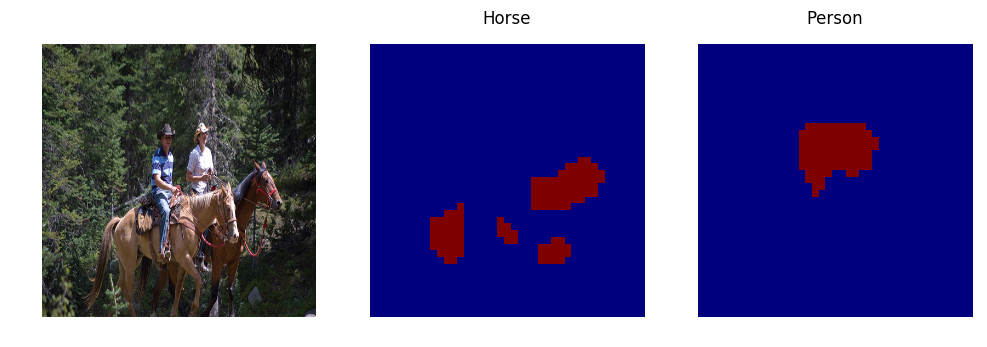

In [6]:
f = plt.figure(figsize=(12, 4))

ax = f.add_subplot(1, 3, 1)
ax.imshow(image, aspect=W / float(H))
ax.axis('off')

ax = f.add_subplot(1, 3, 2)
ax.matshow(localization[12])
ax.set_title('Horse')
ax.axis('off')

ax = f.add_subplot(1, 3, 3)
ax.matshow(localization[14])
ax.set_title('Person')
ax.axis('off')

plt.show()